# Horizon Extension model
The goal of this notebook is to train a model to *segment a specific horizon* and solve the task of *horizon-extension*. In order to solve this task, prediction-time, we provide our model with 1) *ilines* of a seismic cube and 2) small part of a chosen horizon.

* [Task description](#Task-description)
* [Dataset](#Dataset)
* [Data preprocessing](#Data-preprocessing)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Validation](#Validation)
* [Criticism](#Criticism)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)


# Task description

The motivation for the horizon extension setup goes as follows: the creation of a "smart" autocorrelator based on neural networks. In a real-life scenario, a seismic geophysicist marks part of a horizon of interest and then runs autocorrelation software (for instance, [Petrel](https://www.software.slb.com/)) to extend this horizon. However, the autocorrelation software can easily break down on complex parts of seismic cubes, for instance, on faults or salt domes:

<p align="center">
    <img src="images/extension.png" alt="Drawing" style="width: 600px; height: 400px"/>
</p>

This behavior comes as no surprise. The autocorrelator is based on correlations between adjacent seismic traces and stops working properly in steep segments of horizons. On the contrary, convolutional neural networks are more sophisticated and should be able to extend a horizon through complex parts of cubes.

**Note**: Compare this task to the task of [horizon-detection](https://github.com/analysiscenter/seismiqb/blob/models/Horizons_detection.ipynb). Prediction-time, *detection model sees only ilines from seismic cubes*. Hence, it does not distinguish different horizons and attempts to detect all of them. On the contrary, during prediction-stage *extension model sees also a part of a target-horizon*. As a result, we can ask an extension model to *detect a specific horizon*.

In [9]:
# Set the number of GPU-device
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


In [46]:
# Necessary imports
%load_ext autoreload
%autoreload 2
import os
import sys
import logging

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import DenseNetFC, TFModel
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset, plot_loss
# from extension_utils_images import make_slice_prediction, make_cube_prediction, ds_compute_metrics
from utils import *

from glob import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# Dataset

For training we use multiple seismic cubes to prevent overfitting on amplitude values of a specific seismic cube.

We train the model on two cubes: `CUBE_3`, `CUBE_VUONGMK` and test on the third cube `CUBE_1`. A detailed description of each cube, including sample images, is available [here](../datasets/). For now, it is suffice to say that `CUBE_3` and `CUBE_1` are "simple" while `CUBE_VUONGMK` is "difficult" in terms of interpretation complexity.

**Note 1**: In order to train algorithm to segment horizons we need labeled data.
We had 4-9 horizons manually labeled by experts for every cube.



**Note 2**: seismic cube is a 3d entity about 1000 points in each dimension, *it can hardly be fed to a GPU-memory entirely*. Therefore we train our models on crops of smaller shape. To do so we sample random positions in the cubes to take a crop from. Note that different proportions of sampled points are applied to each cube: approximately 80% of crops come from the `CUBE_VUONGMK`, 20% from the `CUBE_3`.

<sub> 

Set paths to seismic cubes and horizon-labels:

In [12]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5',
               '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.hdf5']

dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)

Load info about cube geometries, labels, sampler and lay out some inner structure for fast preprocessing later. For more details look into [SeismicCubeset tutorial](./../tutorials/1.%20Cubeset.ipynb).
Also here we set proportions for sampling crops from the cubes.

In [13]:
%%time
ds = ds.load(p=[0.2, 0.8])

CPU times: user 31.9 s, sys: 8.23 s, total: 40.1 s
Wall time: 40.1 s


# Data preprocessing

We organize our code using [Batchflow](https://github.com/analysiscenter/batchflow/) python library. In the next section we set up a [pipeline](): a sequence of actions we want to perform on data. It consists of three parts:
* `preprocessing`-part, that samples crops positions and loads data and masks for training
* `augmentation`-part with a couple of augmentations including random `rotate` and `scale` to prevent overfitting
* `training`-part that trains both models under the same conditions in the sense of data fed to the model.

During training we will crop data only from the first 80 % of the cubes. To do so we set boundaries for the sampler:

In [16]:
ds.modify_sampler('truncated_sampler', low=0.0, high=0.8, finish=True)

In [17]:
# create number of crops per batch and shape constants
NUM_CROPS = 64
CROP_SHAPE = [2, 64, 64]                                       # i, x, h

Define `preprocessing` pipeline that samples random crop positions, loads crops from seismic cubes, applies min-max scaling, creates masks from the horizons coordinates saved in point cloud and transposes data so the last axis has the smaller size:


In [21]:
preprocessing = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=D('truncated_sampler')(NUM_CROPS), shape=CROP_SHAPE)
                 .load_cubes(dst='images')
                 .create_masks(dst='masks', width=2, single_horizon=True)
                 .rotate_axes(src=['images', 'masks'])
                 .scale(mode='normalize', src='images'))

Recall the task description - in order to segment a specific horizon we have to provide data about it to the model. To do so we thin out a target mask and leave 10-15 percents of it nonzero.

Add action that thins out mask and saves it into `cut_mask_crops`-component of the batch.

In [22]:
preprocessing += (Pipeline().filter_out(src='masks', dst='cut_masks',
                                         expr=lambda m: m[:, 0],
                                         low=R('uniform', low=0.3,high=0.4),
                                         high=R('uniform', low=0.40, high=0.45)))

Let's have a look on the input data, target mask and thin-out mask.

Images from P_cube


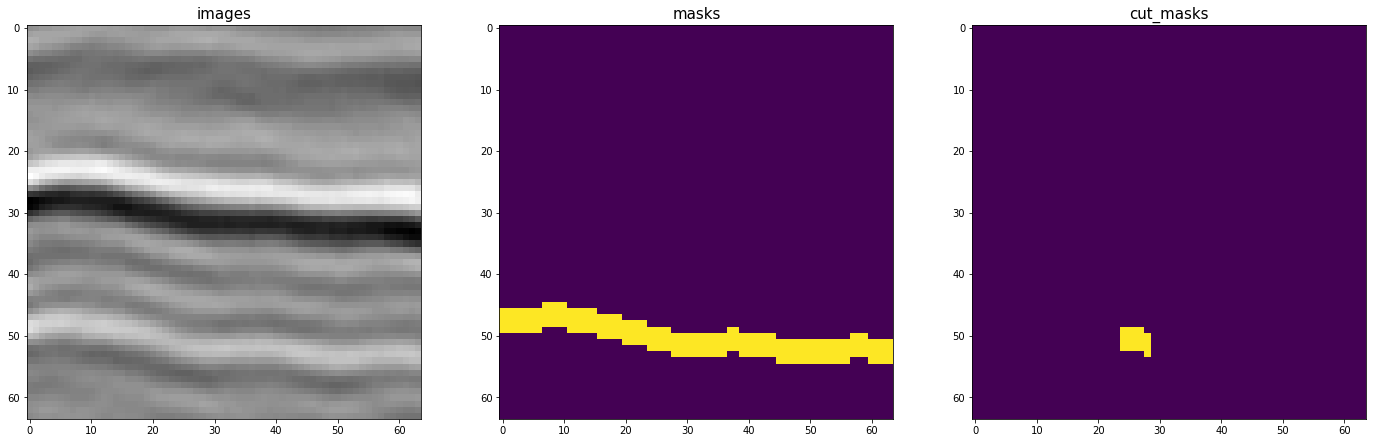

In [24]:
show_ppl = preprocessing << ds
btch = show_ppl.next_batch(2)
btch.plot_components(1, 'images', 'masks', 'cut_masks', overlap=False)

Define `augmentation` that adds some random augmentations:

In [25]:
augmentation = (Pipeline()
               .additive_noise(scale=0.005, src='images', p=0.2)
               .rotate(angle=P(R('uniform', -30, 30)),
                       src=['images', 'masks', 'cut_masks'], p=0.4)
               .scale_2d(scale=P(R('uniform', 0.7, 1.3)),
                         src=['images', 'masks', 'cut_masks'], p=0.4)
               .cutout_2d(patch_shape=P(R('uniform', 5, 15, size=2)),
                          n=P(R('uniform', 3, 7)), src='images')
               .elastic_transform(alpha=P(R('uniform', 35, 45)),
                                  sigma=P(R('uniform', 4, 4.5)),
                                  src=['images', 'masks', 'cut_masks'], p=0.2))

# Model architecture

For proof-of-concept demonstration **we will train two models**: 1) horizon extension model with a prior mask as an additional input to the model and 2) a standard [horizon detection model](https://github.com/analysiscenter/seismiqb/blob/models/Horizons_detection.ipynb) with the same architecture that we will use as a baseline.

We solve our task as a binary segmentation problem classifying every pixel of an input image on two classes - whether the pixel belongs to a horizon or not.

We work with [FC-DenseNet](https://arxiv.org/abs/1611.09326) architecture with 5 dense blocks in encoder. Each block consists of 4 convolutional layers and has `growth_rate = 8` (number of feature maps in the output of each convolutional layer).

We will train both models on 3d crops with size (64, 64, 2) but use 2d convolutions providing third dimension of an input tensor as channel dimension.

For the horizon extension model we take a crop and corresponding target mask, zero-out target mask except for a small part of it and feed to the model a concatenation of crop and thin-out mask.

Set up shapes needed for extension and detection-models:

In [26]:
# create shape constants for model input and output
MODEL_SHAPE = [CROP_SHAPE[i] for i in(1, 2, 0)]               # x, h, i
MODEL_SHAPE_DICE = tuple(MODEL_SHAPE + [1])
INPUT_SHAPE_EXT = MODEL_SHAPE[:2] + [MODEL_SHAPE[-1] * 2]

Define configuration-dictionaries for both models:

In [27]:
model_config_common = {'initial_block/inputs': 'images',
                      'body': {'num_layers': [4]*5,
                               'block/growth_rate': 8, 'block/skip': True},
                      'loss': 'dice',
                      'optimizer': 'Adam',
                      'predictions': predictions,
                      'output': 'sigmoid',
                      'common': {'data_format': 'channels_last'}}

model_config_ext = {'inputs/images/shape': INPUT_SHAPE_EXT,
                    'inputs/masks/shape': MODEL_SHAPE_DICE, **model_config_common}

model_config_base = {'inputs/images/shape': MODEL_SHAPE,
                     'inputs/masks/shape': MODEL_SHAPE_DICE, **model_config_common}

# Training

For the *extension* model we concatenate seismic data and thin-out mask along the last axis. Creation of the feed dict is define in [make_data_extension](./utils.py).

For the *baseline* horizon detection model we use the same architecture and train the model providing it with seismic data only.

Define training pipeline to train both models:

In [40]:
training = (Pipeline()
            .add_axis(src='masks', dst='masks')
            .init_variables(dict(loss_history=dict(init_on_each_run=list),
                                 ext_loss_history=dict(init_on_each_run=list)))
            .init_model('dynamic', DenseNetFC, 'base', model_config_base)
            .train_model('base', fetches='loss',
                         images=B('images'), masks=B('masks'),
                         save_to=V('loss_history', mode='a'))
            .init_model('dynamic', DenseNetFC, 'extension', model_config_ext)
            .train_model('extension',
                         fetches='loss',
                         make_data=make_data_extension,
                         save_to=V('ext_loss_history', mode='a'),
                         use_lock=True))

Assemble whole processs pipeline using pipelines arithmetics:

In [41]:
train_pipeline = (preprocessing + augmentation + training) << ds

As it was defined in the model config we will train model with Adam optimizer with defult hyperparameters on the crops of fixed size.

We train both models on the same batches for `2000` iterations with `batch_size=64`:

In [42]:
EPOCHS = 2000

In [47]:
train_pipeline.run(D('size'), n_iters=EPOCHS, bar=True,
                   bar_desc=W(V('loss_history')[-1].format('Loss is: {:7.7}')))

Loss is: -0.1925514: 100%|██████████| 2/2 [01:05<00:00, 44.68s/it]


In [38]:
%%time
train_batch = train_pipeline.next_batch(2, n_epochs=None)

CPU times: user 1min, sys: 3.56 s, total: 1min 4s
Wall time: 1min 5s


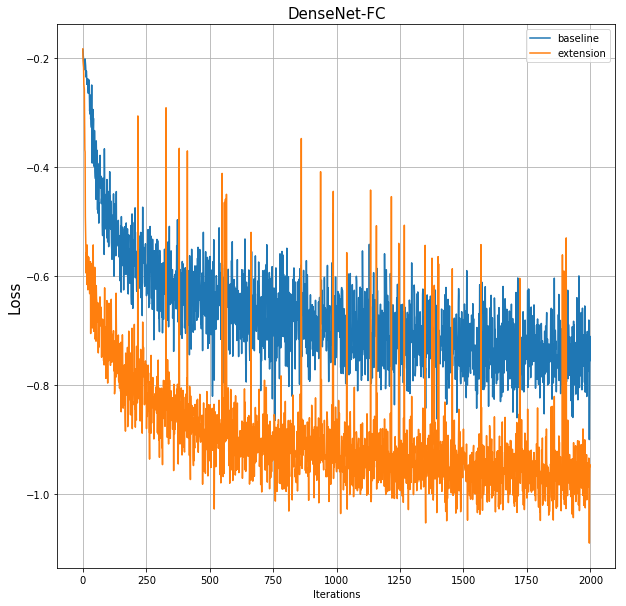

In [21]:
plot_loss([train_pipeline.v('loss_history'), train_pipeline.v('ext_loss_history')],
            ['baseline', 'extension'], ylabel='Loss', title='DenseNet-FC')

# Validation

In this part we will take a look at the segmentation results of our models on two types of data:
1. [Test](#Test-on-the-same-cubes) on the rest 20% of the `CUBE_3` and `CUBE_VUONGMK` cubes that weren't used during the training.
* [Test](#Test-on-new-cube) on `CUBE_1` that wasn't used during the training.
* After we will [assemble predictions on a grid of crops](#In-the-big-picture) and see the segmentation results on a big slide.

### Test on the same cubes

Define `test_pipeline` that imports models from `train_pipeline` and runs `predict_model`

In [49]:
test_pipeline = (Pipeline()
                 .add_axis(src='masks', dst='masks')
                 .import_model('base', train_pipeline)
                 .init_variable('result', init_on_each_run=list())
                 .predict_model('base',
                                fetches=['images', 'masks', 'predictions', 'loss'],
                                images=B('images'), masks=B('masks'),
                                save_to=V('result'))
                 .import_model('extension', train_pipeline)
                 .init_variable('ext_result', init_on_each_run=list())
                 .predict_model('extension',
                                fetches=['images', 'masks', 'predictions', 'loss'],
                                make_data=make_data_extension,
                                save_to=V('ext_result')))

Set new boundaries for the sampler so we crop from the rest 20% of the cubes:

In [50]:
ds.modify_sampler('truncated_sampler', low=0.8, high=1, finish=True)

Define pipeline that loads data from the same cubes and performs test:

In [54]:
test_on_same_cubes = (preprocessing + test_pipeline) << ds

Show the results of segmentation for the baseline horizon detection model (column 4) and extension model (column 5)

Loss is:  -0.999916
P_cube


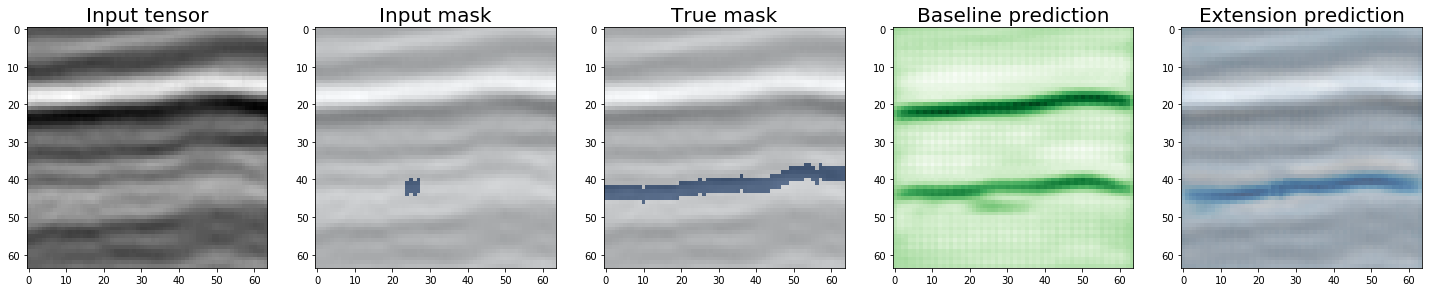

Repaired_cube


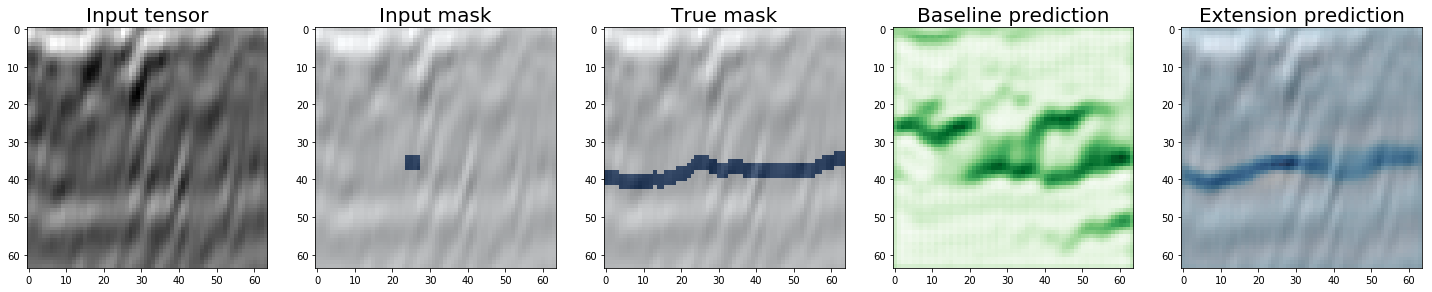

Repaired_cube


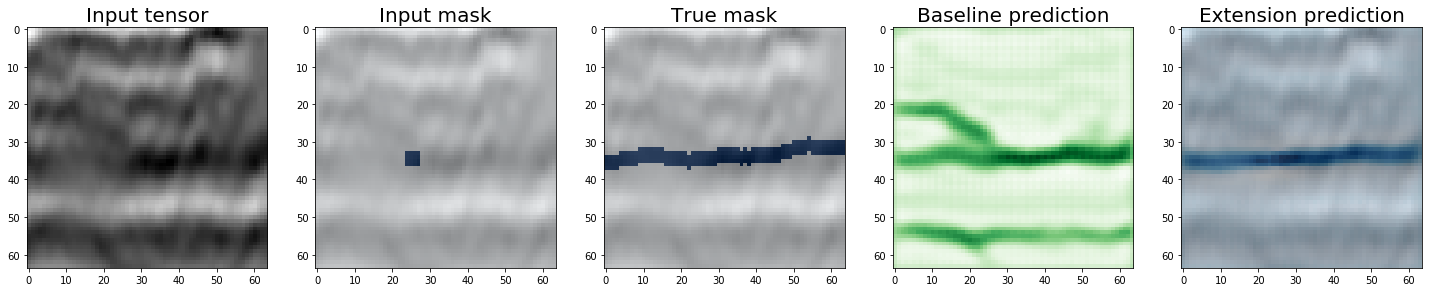

P_cube


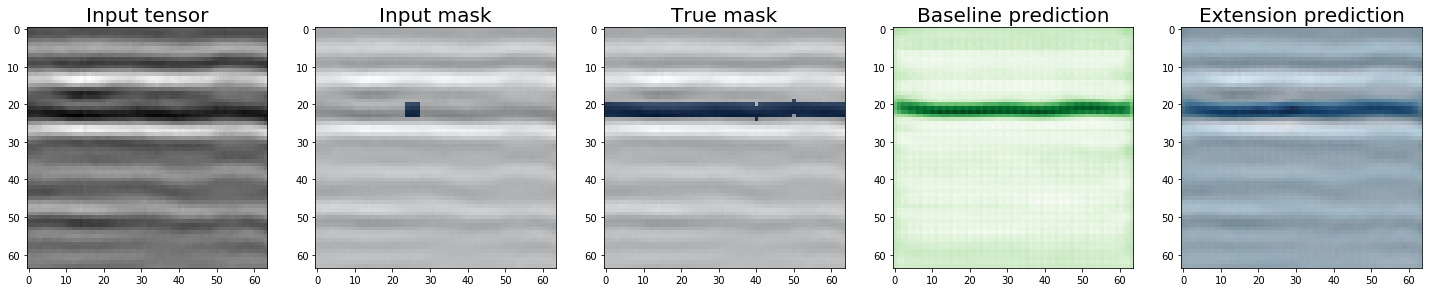

In [33]:
test_batch = test_on_same_cubes.next_batch(2, n_epochs=None)

cubes_numbers = np.random.choice(NUM_CROPS, 4)
print('Loss is: ', test_on_same_cubes.get_variable('ext_result')[3])
show_extension_results(test_batch, test_on_same_cubes, cubes_numbers)

### Test on new cube

Load Cube_1 that wasn't used during the training:

In [56]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5']
test_ds_idx = FilesIndex(path=paths_cubes, no_ext=True)
test_ds = SeismicCubeset(test_ds_idx)
test_ds = test_ds.load()

In [57]:
test_ds.modify_sampler('truncated_sampler', low=0.0, high=1, finish=True)

Define test pipeline that will load data from new cube:

In [58]:
test_on_third = (preprocessing + test_pipeline) << test_ds

Predict on batch:

In [59]:
batch = test_on_third.next_batch(1, n_epochs=None)

Show results:

Loss is:  -0.8894589
E_anon


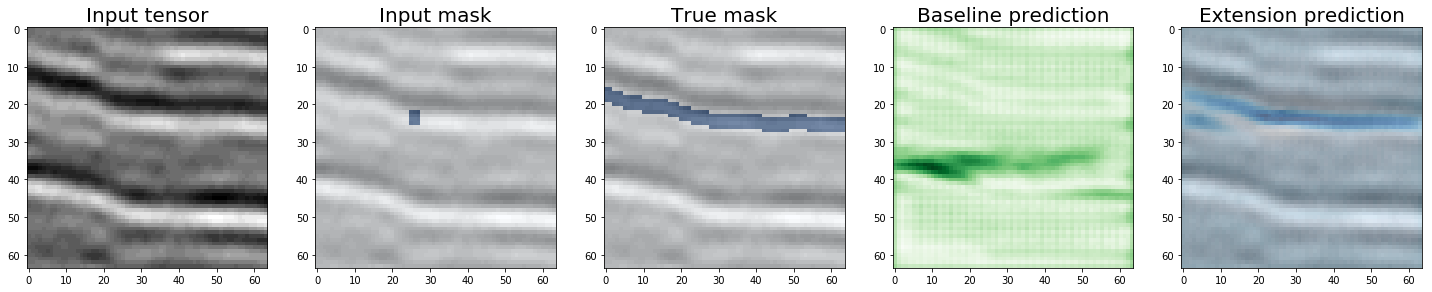

E_anon


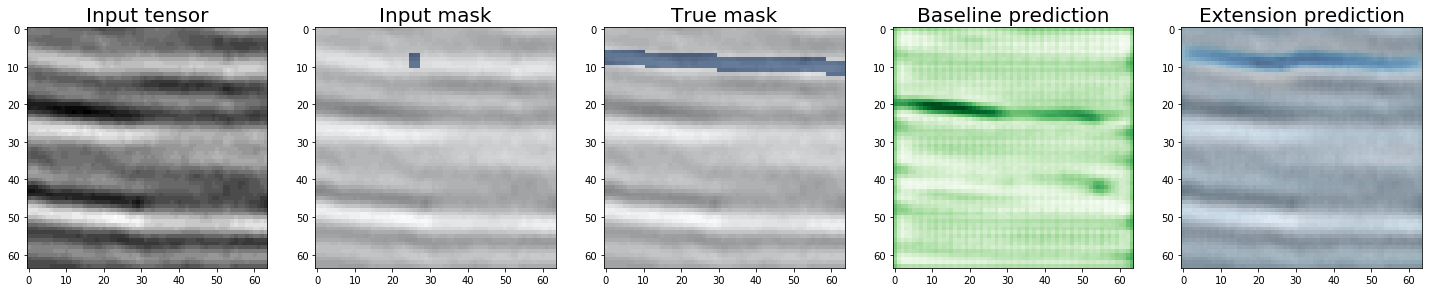

E_anon


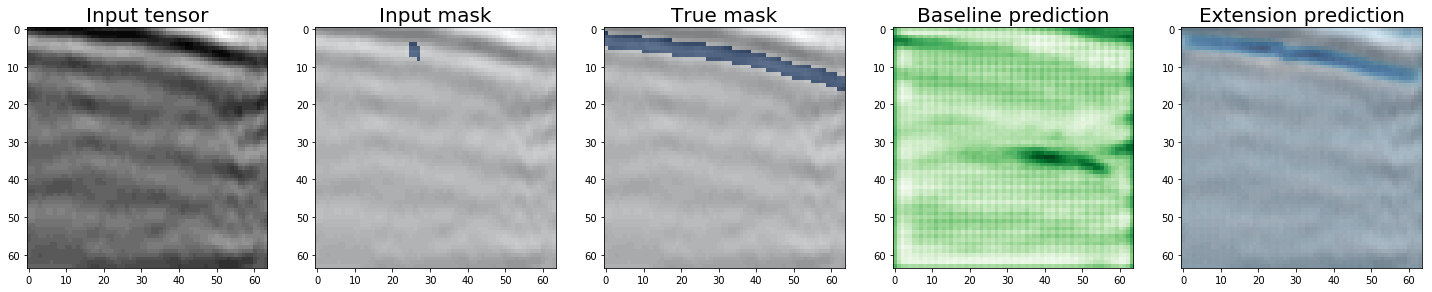

E_anon


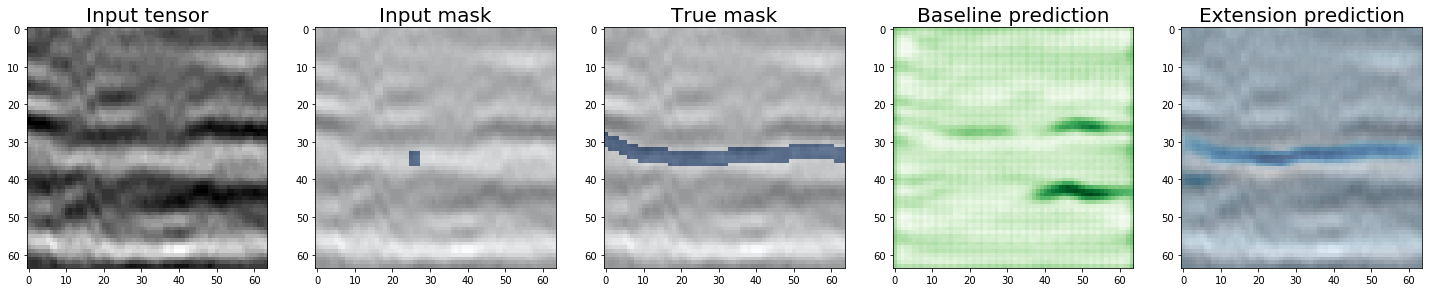

In [45]:
cubes_numbers = np.random.choice(NUM_CROPS, 4)
print('Loss is: ', test_on_third.get_variable('ext_result')[3])
show_extension_results(batch, test_on_third, cubes_numbers)

# In the big picture

Our model extends the horizon for a crop of a fixed size. To get a horizon on a whole slice or cube we need to run a special function that will sequentially run predict on a grid of overlapping crops so that each subsequent crop can use predicted mask from the previous crop as a prior mask needed for the model setup.

Again, first, we load cube metadata to an instance of SeismicCubeset `test_ds`:

In [6]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5']
test_ds_idx = FilesIndex(path=paths_cubes, no_ext=True)
test_ds = SeismicCubeset(test_ds_idx)
test_ds = test_ds.load()

Load pretrained model that wasn't trained on this cube:

In [7]:
predict_pipeline = (Pipeline()
                     .load_model('dynamic', TFModel, 'extension', path='./test_cube_3_1_08/') << test_ds)
predict_pipeline.next_batch(1)

Define slice area:

In [11]:
p_start_points = [1709, 1253, 527]

Next functions take true beginning the horizon, extends it and save to `predicted_labels` component of dataset.

Method `subset_labels` takes a crop of a fixed shape and saves its mask to `prior_mask` component of our `test_ds`. In a real world scenario this small area can be labeled by an expert or an autocorrelation algorithm.

In [ ]:
test_ds.subset_labels(p_start_points, crop_shape=[2, 64, 64], cube_index=0, show_prior_mask=False)

Having the beginning of the horizon we run `make_slice_prediction` that run subsequent predict on overlapping crops:

In [ ]:
test_ds.update_labels()
test_ds.make_slice_prediction(predict_pipeline, p_start_points, [2, 64, 64],
                              max_iters=70, show_count=0, slide_direction='xline',
                              WIDTH=20, threshold=0.01)

Compute metrics:

Mean value/std of error:                  1.428571 / 1.265951
Horizont length:                          873
Rate in 5 ms window:                      0.8051948
Average height/std of true horizont:      560.9386
Average height/std of predicted horizont: 558.8737
Number of values that were labeled by model and not labeled by experts: 26


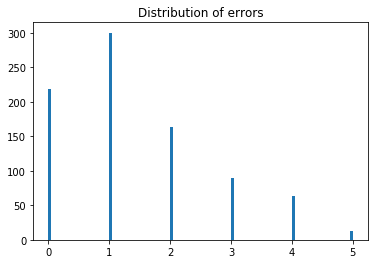

In [14]:
test_ds.show_metrics(cube_index=0, time_interval=2.5)

Show results for a slice:

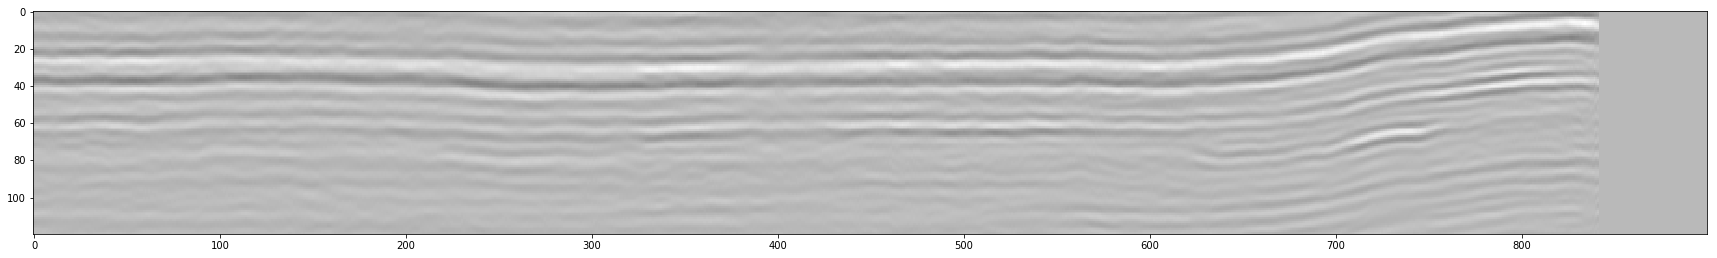

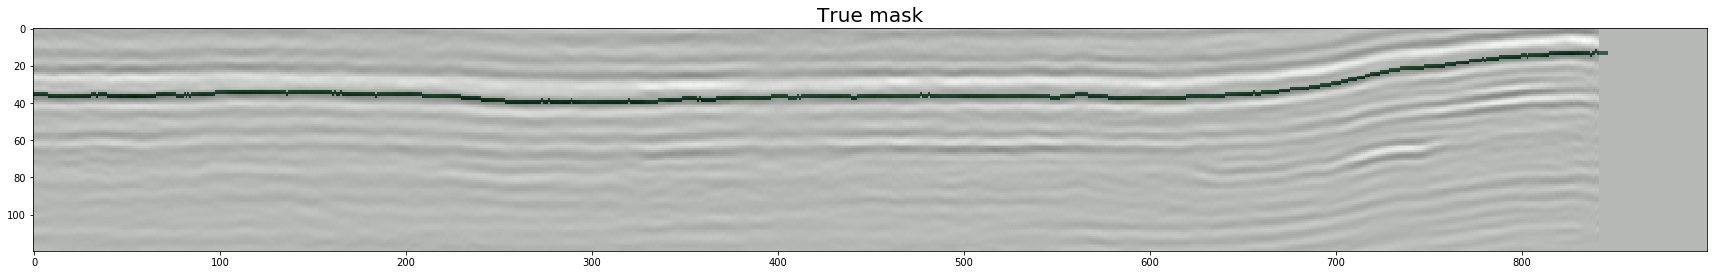

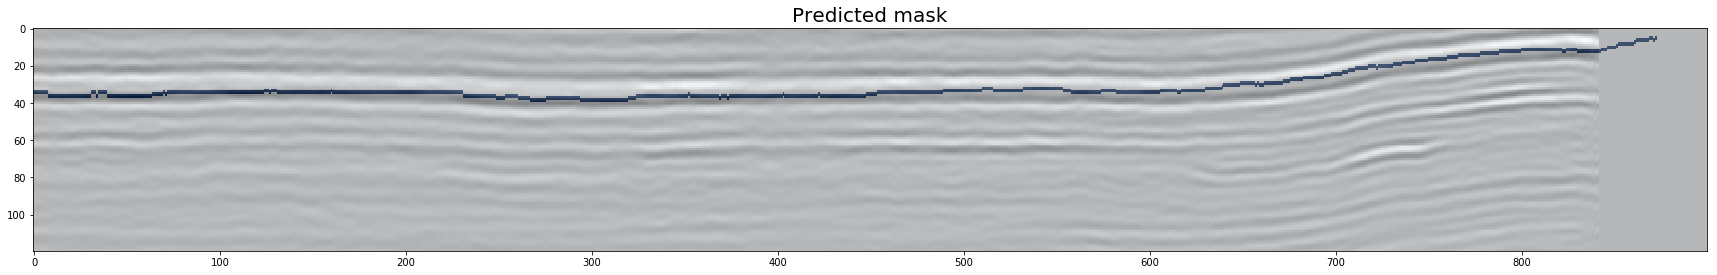

In [17]:
test_ds.show_saved_horizon(p_start_ranges, None)

# Criticism

Although model shows satisfactory results on crops, whole area prediction task it to be improved.
In simple cases like Cube_3 where horizons are easy to track and the horizon extension procedure works quite well but in more complicated cases with faults, sault domes and noisy traces current extension procedure fails to track the horizon labeled by an expert.

Here is table of metrics (area of detected horizon that is closer than 5ms to the ground truth) for some plain horizons on different cubes:

| Train/test cube |  Length | Test on same cube, % | Test on new cube, % |
| :------ | ----: | ----: | ----: |
| CUBE_3 | 844  | 100 | 92.1 |
| CUBE_1 | 974  | 39.9 | 39.9 | 
| CUBE_VU_ONGMK |  1157 | 59.5  | 55 |


We see a significant decrease in metrics on Cube_1 and Cube_VU_ONGMK that have a more complicated geologic structure than Cube_3.
It happens mostly due to the error sensitivity of the extension procedure that is performed subsequently on overlapping crops. If once we make a mistake and miss the true phase we will hardly get back to the initial horizon.


# Proposals for the improvement and further development

The horizon extension procedure makes a subsequent predict on one crop at a time and takes more than 2 hours to track a horizon on a whole Cube_3. It can be sufficiently sped up by running prediction for different slices in parallel.

Also, it is crucial to improve model performance on non-trivial horizons, for example by providing additional information about the horizon to the model to reduce the chance of changing phase.